In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

In [2]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(tools))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(Matrix.utils))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(sva))
source("/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/gastruloids_scRNAseq/plotting_settings.R")

In [3]:
metadata <- fread('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/other_data/gouti2014/E-MTAB-2268.sdrf.txt') %>% as.data.frame
rownames(metadata) <- metadata$`Source Name`
metadata$sampletype <- unlist(lapply(metadata$`Source Name`, function(sn) strsplit(sn, '_')[[1]][1]))
head(metadata)

,Source Name,Comment[ENA_SAMPLE],Material Type,Provider,Characteristics[organism],Characteristics[specimen with known storage state],Characteristics[genotype],Characteristics[cell type],Protocol REF,Protocol REF.1,⋯,Technology Type,Comment[ENA_EXPERIMENT],Scan Name,Comment[SUBMITTED_FILE_NAME],Comment[ENA_RUN],Comment[FASTQ_URI],Comment[MD5],Factor Value[time],Unit[time unit],sampletype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
D1_1,D1_1,ERS423599,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425731,Sample_405.fastq.gz,Sample_405.fastq.gz,ERR459376,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459376/ERR459376.fastq.gz,576a048f279bab11f313bcd57aad3444,1,day,D1
D1_2,D1_2,ERS423603,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425735,Sample_406.fastq.gz,Sample_406.fastq.gz,ERR459395,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459395/ERR459395.fastq.gz,81ced8b551592a1a698e1840d18d4789,1,day,D1
D1_3,D1_3,ERS423614,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425746,Sample_407.fastq.gz,Sample_407.fastq.gz,ERR459387,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459387/ERR459387.fastq.gz,5e570d314c2a5cf791783f548284e2e0,1,day,D1
D2_1,D2_1,ERS423595,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425727,Sample_408.fastq.gz,Sample_408.fastq.gz,ERR459379,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459379/ERR459379.fastq.gz,240854834cdf6e1149a1c60c893924db,2,day,D2
D2_2,D2_2,ERS423592,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425724,Sample_409.fastq.gz,Sample_409.fastq.gz,ERR459385,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459385/ERR459385.fastq.gz,a3d26e675778acd9ebd221fdef655a8a,2,day,D2
D2_3,D2_3,ERS423608,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425740,Sample_410.fastq.gz,Sample_410.fastq.gz,ERR459388,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459388/ERR459388.fastq.gz,1146612b806f835ebb721cac8bf22b8a,2,day,D2


In [4]:
counts <- read.table('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/other_data/gouti2014/counts.csv', sep=',', header=TRUE)
rownames(counts) <- counts$id
counts$id <- NULL
counts <- as.matrix(counts)[substr(rownames(counts),1,2) != '__',]
counts

,D1_1,D1_2,D1_3,D2_1,D2_2,D2_3,D2.5_1,D2.5_2,D2.5_3,W2.5_1,⋯,W5_3,M5_1,M5_2,M5_3,A4_1,A4_2,A4_3,A5_1,A5_2,A5_3
ENSMUSG00000000001,4590,5013,5203,5325,6047,5789,4797,5056,5927,5083,⋯,4405,4011,3845,2797,5202,3610,2648,3133,3426,6068
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028,1305,1436,1427,991,1057,1153,986,1019,1076,1016,⋯,1268,1147,1106,1030,1169,918,620,640,835,1434
ENSMUSG00000000031,1129,1203,1149,280,294,346,339,371,413,309,⋯,2312,2278,2621,2490,349,209,154,127,208,293
ENSMUSG00000000037,68,83,87,64,74,69,103,92,127,254,⋯,195,226,275,189,139,84,89,103,135,162
ENSMUSG00000000049,0,2,3,1,2,0,1,3,2,4,⋯,3,2,0,0,3,0,0,2,0,2
ENSMUSG00000000056,582,589,661,532,585,647,1068,1020,1084,505,⋯,631,426,447,491,921,1051,705,788,1091,1690
ENSMUSG00000000058,51,77,63,37,38,39,36,40,48,32,⋯,30,14,15,7,45,22,24,5,10,15
ENSMUSG00000000078,1456,1518,1514,1919,2031,1931,2462,2872,3521,1861,⋯,795,518,577,474,1176,1208,881,754,801,1178
ENSMUSG00000000085,226,260,300,203,221,272,296,274,358,427,⋯,415,656,692,551,396,237,176,201,244,410


In [5]:
metadata <- metadata[colnames(counts),]
metadata

,Source Name,Comment[ENA_SAMPLE],Material Type,Provider,Characteristics[organism],Characteristics[specimen with known storage state],Characteristics[genotype],Characteristics[cell type],Protocol REF,Protocol REF.1,⋯,Technology Type,Comment[ENA_EXPERIMENT],Scan Name,Comment[SUBMITTED_FILE_NAME],Comment[ENA_RUN],Comment[FASTQ_URI],Comment[MD5],Factor Value[time],Unit[time unit],sampletype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
D1_1,D1_1,ERS423599,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425731,Sample_405.fastq.gz,Sample_405.fastq.gz,ERR459376,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459376/ERR459376.fastq.gz,576a048f279bab11f313bcd57aad3444,1.0,day,D1
D1_2,D1_2,ERS423603,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425735,Sample_406.fastq.gz,Sample_406.fastq.gz,ERR459395,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459395/ERR459395.fastq.gz,81ced8b551592a1a698e1840d18d4789,1.0,day,D1
D1_3,D1_3,ERS423614,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425746,Sample_407.fastq.gz,Sample_407.fastq.gz,ERR459387,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459387/ERR459387.fastq.gz,5e570d314c2a5cf791783f548284e2e0,1.0,day,D1
D2_1,D2_1,ERS423595,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425727,Sample_408.fastq.gz,Sample_408.fastq.gz,ERR459379,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459379/ERR459379.fastq.gz,240854834cdf6e1149a1c60c893924db,2.0,day,D2
D2_2,D2_2,ERS423592,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425724,Sample_409.fastq.gz,Sample_409.fastq.gz,ERR459385,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459385/ERR459385.fastq.gz,a3d26e675778acd9ebd221fdef655a8a,2.0,day,D2
D2_3,D2_3,ERS423608,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425740,Sample_410.fastq.gz,Sample_410.fastq.gz,ERR459388,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459388/ERR459388.fastq.gz,1146612b806f835ebb721cac8bf22b8a,2.0,day,D2
D2.5_1,D2.5_1,ERS423611,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425743,Sample_411.fastq.gz,Sample_411.fastq.gz,ERR459386,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459386/ERR459386.fastq.gz,31df1b68ec3300149969751fc94f7fed,2.5,day,D2.5
D2.5_2,D2.5_2,ERS423604,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425736,Sample_412.fastq.gz,Sample_412.fastq.gz,ERR459393,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459393/ERR459393.fastq.gz,b817ee74b4e2089ab59eb4e5053a5e69,2.5,day,D2.5
D2.5_3,D2.5_3,ERS423598,cell,J.Briscoe Lab,Mus musculus,frozen specimen,wild type genotype,mouse embryonic stem cell,P-MTAB-37783,P-MTAB-37784,⋯,sequencing assay,ERX425730,Sample_413.fastq.gz,Sample_413.fastq.gz,ERR459405,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR459/ERR459405/ERR459405.fastq.gz,9f8ebe504f9bb2f26d598fe3320619d1,2.5,day,D2.5


In [6]:
### Check that sample names match in both files
all(colnames(counts) %in% rownames(metadata))
all(colnames(counts) == rownames(metadata))

[1] TRUE

[1] TRUE

In [7]:
srat <- readRDS('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/seurat_final.rds')
g_meta <- fread('/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/sample_metadata_final.txt.gz')
g_meta[MULTI_class %in% as.vector(unlist(neural)), gastr_type := "neural"]
g_meta[MULTI_class %in% as.vector(unlist(mesodermal)), gastr_type := "mesodermal"]
g_meta[MULTI_class %in% as.vector(unlist(intermediate)), gastr_type := "intermediate"]

In [8]:
srat <- subset(srat, subset = (MULTI_class != 'Negative') & (MULTI_class != 'Doublet') & (MULTI_class != 'unidentifiable') & (tech=="MULTI"))
exps <- unique(srat@meta.data$experiment)
days <- unique(srat@meta.data$timepoint)
gastruloids <- unique(srat@meta.data$MULTI_class)
pb <- list()
for (exp in exps) {
    
    pb[[exp]] <- list()
    
    for (day in days) {
        
        if (any((srat@meta.data$experiment == exp) & (srat@meta.data$timepoint == day))) {
        
            srat_sub <- subset(srat, subset = (timepoint==day) & (experiment==exp))

            # Create single cell experiment object
            sce <- SingleCellExperiment(assays = list(counts = srat_sub@assays$RNA@counts[rownames(srat_sub@assays$RNA@meta.features)[!(srat@assays$RNA@meta.features$cc_gene)],]), 
                                       colData = srat_sub@meta.data)

            # Aggregate the counts per sample_id and cluster_id

            # Subset metadata to only include the cluster and sample IDs to aggregate across
            groups <- colData(sce)[, c("MULTI_class")]

            # Aggregate across cluster-sample groups
            pb[[exp]][[day]] <- aggregate.Matrix(t(counts(sce)), 
                                                 groupings = groups, fun = "sum")
            
        }
        
    }
    
    pb[[exp]] <- rBind.fill(pb[[exp]])
    
}
pb <- rBind.fill(pb)

In [9]:
pb_meta <- unique(g_meta[MULTI_class %in% rownames(pb),c("timepoint", "MULTI_class", "gastr_type", "organoid", "experiment")]) %>% as.data.frame
pb_meta$sample <- pb_meta$MULTI_class
pb_meta$sampletype <- paste0(pb_meta$timepoint, '_', pb_meta$gastr_type)
rownames(pb_meta) <- pb_meta$MULTI_class
pb_meta <- pb_meta[rownames(pb),]

In [10]:
metadata$sample <- metadata$`Source Name`
metadata$organoid <- '2D'
metadata$experiment <- 'Briscoe'
metadata$timepoint <- metadata$`Factor Value[time]`
metadata$protocol <- substr(metadata$sampletype,1,1)

In [11]:
#counts.bound <- rBind.fill(pb, t(counts))
counts.bound <- rBind.fill(pb[rownames(pb_meta[pb_meta$timepoint %in% c('d3', 'd3.5'),]),], t(counts))
#meta.bound <- rbind.fill(pb_meta, metadata[,c("organoid", "sample", "timepoint", "sampletype", "experiment", "protocol")]) %>% as.data.frame
meta.bound <- rbind.fill(pb_meta[pb_meta$timepoint %in% c('d3', 'd3.5'),], metadata[,c("organoid", "sample", "timepoint", "sampletype", "experiment", "protocol")]) %>% as.data.frame
rownames(meta.bound) <- meta.bound$sample
meta.bound <- meta.bound[rownames(counts.bound),]
counts.bound <- t(counts.bound)

In [12]:
dds <- DESeqDataSetFromMatrix(countData = counts.bound, colData = meta.bound, design = ~ experiment)
#dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ timepoint + protocol)
#dds <- DESeqDataSetFromMatrix(countData = counts, colData = metadata, design = ~ 1)
dds <- estimateSizeFactors(dds)
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [13]:
#rld <- rlog(dds, blind=FALSE)
vsd <- vst(dds, blind=FALSE)
head(assay(vsd), 3)

,Bar12_exp4_d3,Bar13_exp4_d3,Bar14_exp4_d3,Bar15_exp4_d3,Bar18_exp4_d3,Bar19_exp4_d3,Bar2_exp4_d3,Bar20_exp4_d3,Bar24_exp4_d3,Bar25_exp4_d3,⋯,W5_3,M5_1,M5_2,M5_3,A4_1,A4_2,A4_3,A5_1,A5_2,A5_3
ENSMUSG00000051951,6.956423,6.679147,7.030190,7.174415,7.109077,7.016591,7.061578,7.186762,7.146762,6.908085,⋯,6.328667,6.528331,6.466714,6.883889,6.826695,7.193658,7.123708,6.706622,6.599369,6.666734
ENSMUSG00000025900,6.240337,5.788665,5.788665,5.788665,5.788665,6.058043,5.788665,6.140308,5.788665,5.788665,⋯,5.788665,5.788665,5.788665,5.933417,5.919167,6.008732,6.049707,6.033526,5.788665,5.911111
ENSMUSG00000025902,10.670684,7.375599,6.466698,8.398359,8.255257,7.641142,7.087260,7.186762,6.591632,7.744013,⋯,6.969931,6.816063,6.824797,6.656387,6.508042,7.148274,7.229636,6.333602,6.376084,6.453627


Warning message:
“Computation failed in `stat_binhex()`:
”


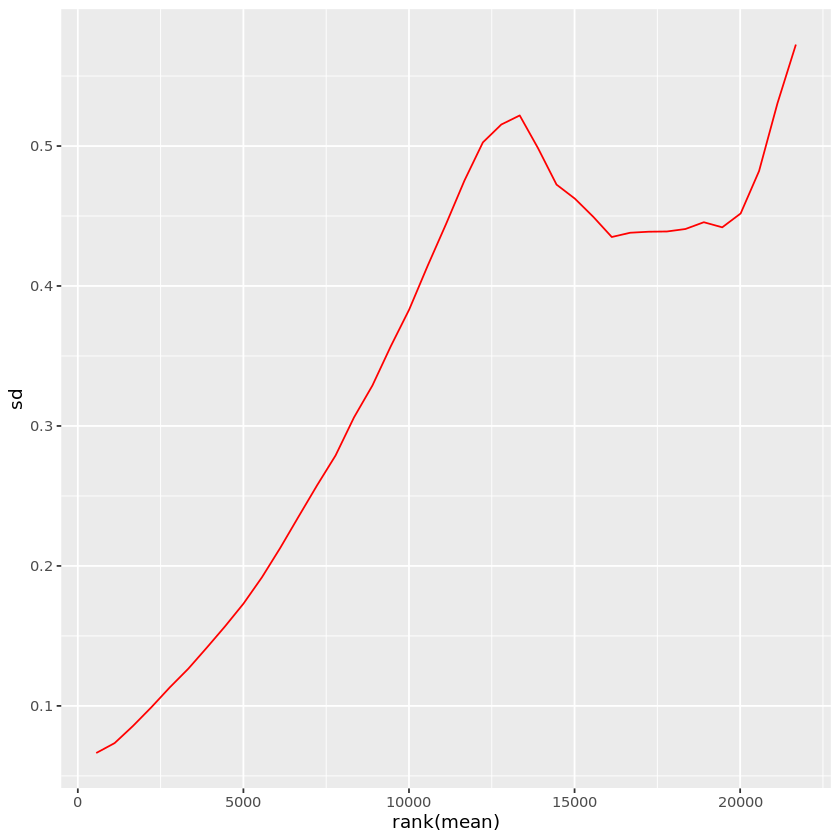

In [14]:
library("vsn")
meanSdPlot(assay(vsd))

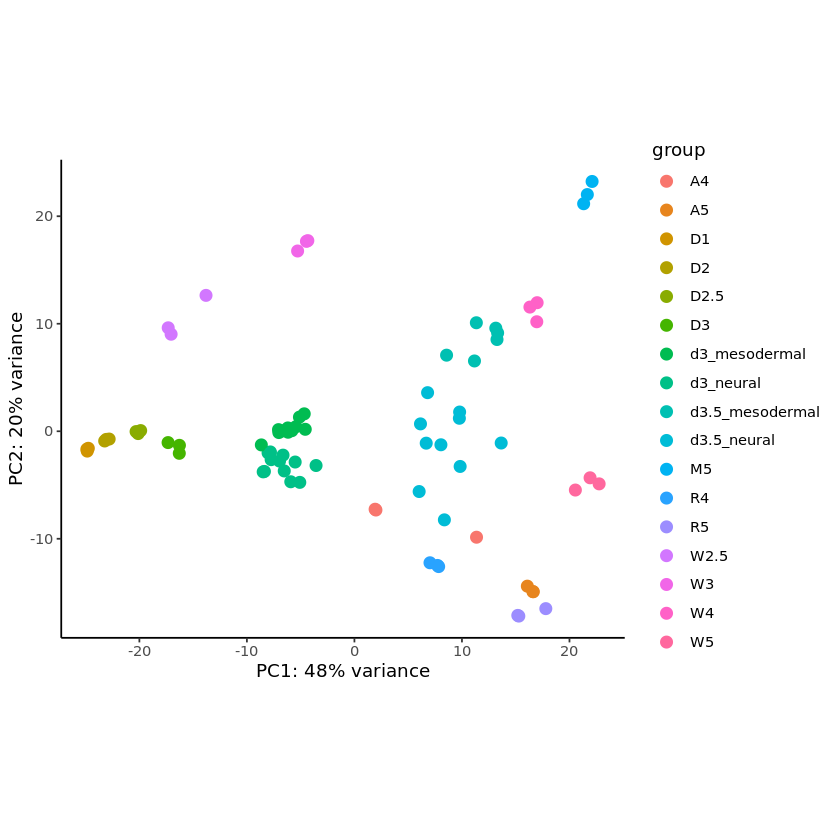

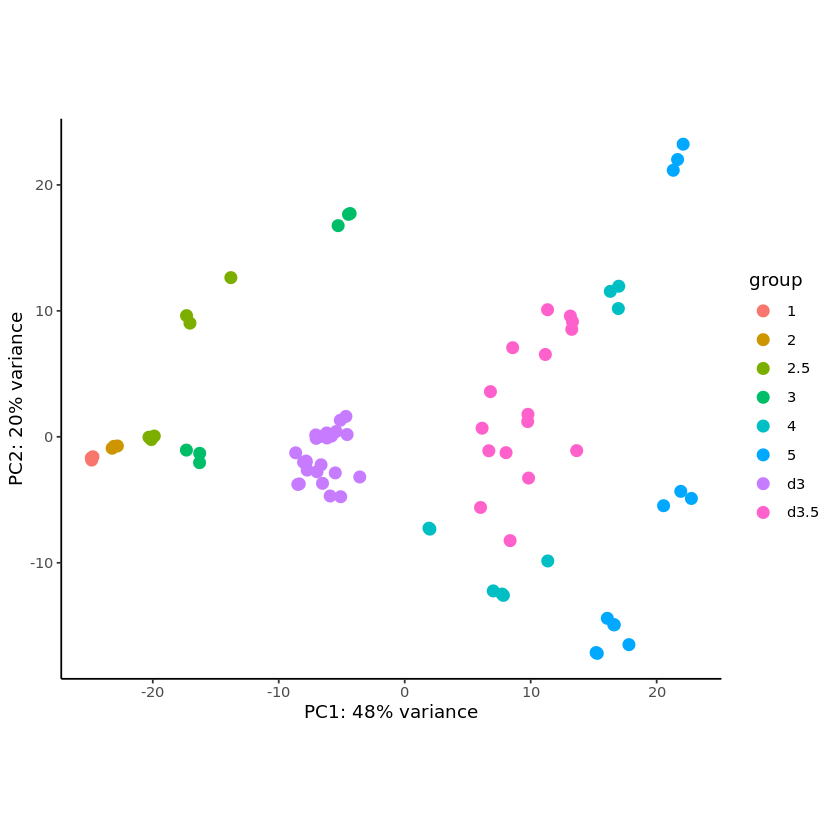

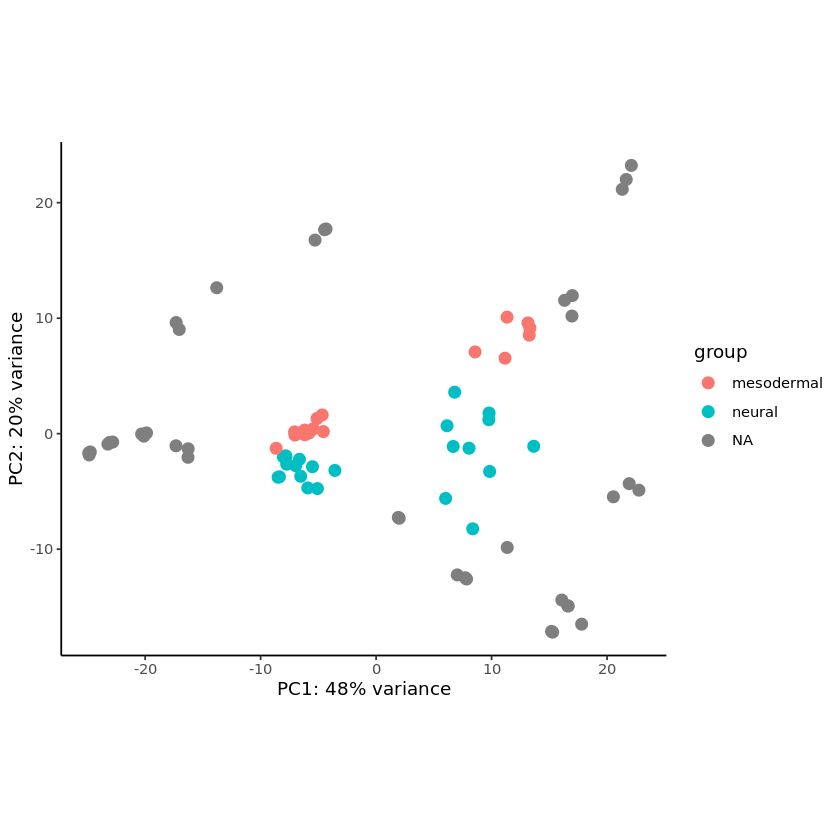

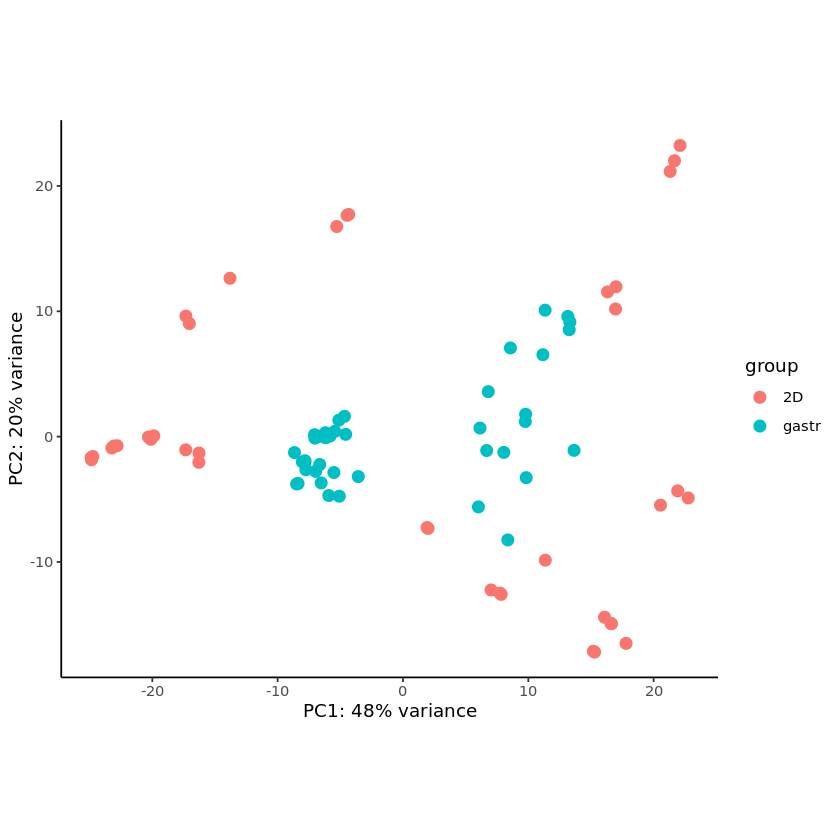

In [15]:
mat <- assay(vsd)
mm <- model.matrix(~1, colData(vsd))
mat <- limma::removeBatchEffect(mat, batch=vsd$organoid, design=mm)
assay(vsd) <- mat
plotPCA(vsd, intgroup=c("sampletype")) + theme_classic()
plotPCA(vsd, intgroup=c("timepoint")) + theme_classic()
plotPCA(vsd, intgroup=c("gastr_type")) + theme_classic()
plotPCA(vsd, intgroup=c("organoid")) + theme_classic()

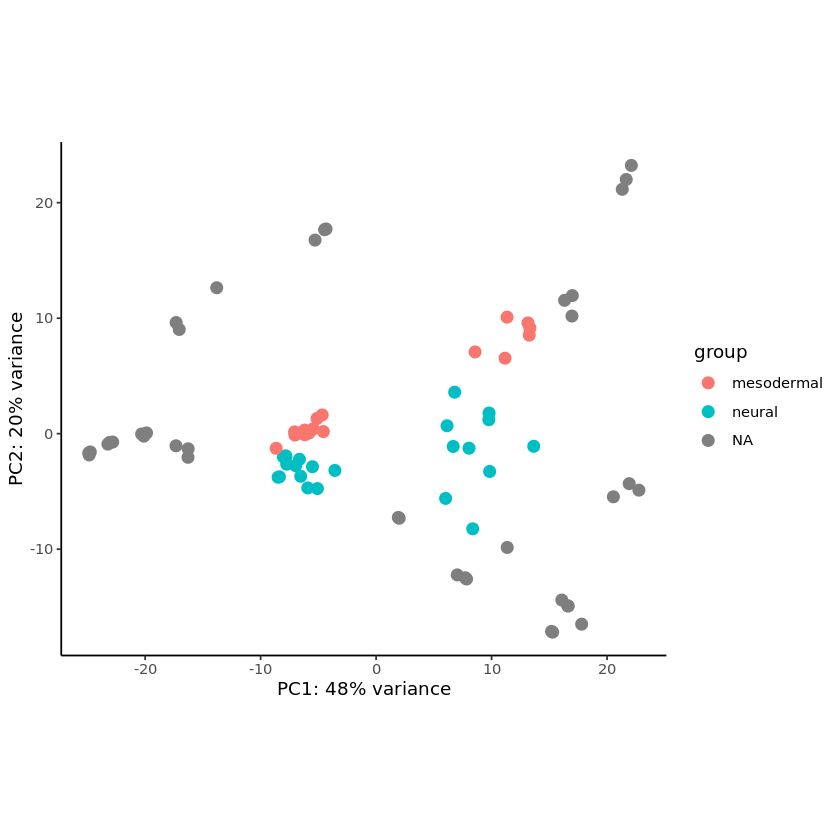

In [16]:
plotPCA(vsd, intgroup=c("gastr_type")) + theme_classic()

In [17]:
get_col <- function(colours) {
    tmp <- round(rowSums(Reduce(cbind, lapply(colours, function(colour) col2rgb(colour))))/length(colours))
    return(rgb(tmp[1], tmp[2], tmp[3], maxColorValue=255))
}


In [18]:
get_col(c("#8911cf", "#cf2bab"))


[1] "#AC1EBD"

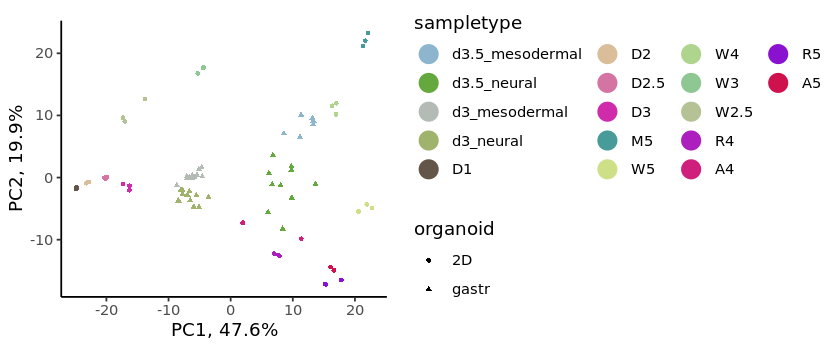

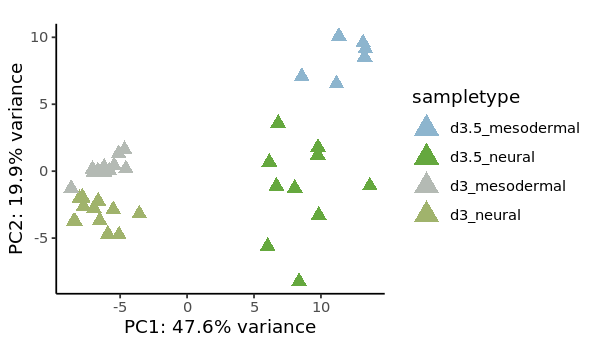

In [38]:
sampletype_colours <- c("d3.5_mesodermal" = "#8DB5CE",
                        "d3.5_neural" = "#65A83E",
                        "d3_mesodermal" = "#B4BAB4",
                        "d3_neural" = "#A0B36C",
                        "D1" = "#635547",
                        "D2" = "#DABE99",
                        "D2.5" = "#D474A2",
                        "D3" = "#cf2bab",
                        "M5" = "#479b98",
                        "W5" = "#CDE088",
                        "W4" = "#AED48D",
                        "W3" = "#8EC792",
                        "W2.5" = "#B4C296",
                        "R4" = "#AC1EBD",
                        "A4" = "#CF1E7C",
                        "R5" = "#8911cf",
                        "A5" = "#cf114d"
                        
                       )
pcaData <- plotPCA(vsd, intgroup=c("sampletype", "organoid"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"),1)
options(repr.plot.width = 7, repr.plot.height = 3)
p <- ggplot(pcaData, aes(PC1, PC2, color=sampletype, shape=organoid)) +
  geom_point(size=1) +
  scale_color_manual(values = sampletype_colours) +
  xlab(paste0("PC1, ",percentVar[1],"%")) +
  ylab(paste0("PC2, ",percentVar[2],"%")) + 
  guides(color=guide_legend(ncol=4, override.aes = list(size=5))) +
  coord_fixed() +
  theme_classic()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/C.pdf',
  plot = p,
  device = 'pdf',
  width = 7,
  height = 3,
  units = "in"
)
options(repr.plot.width = 5, repr.plot.height = 3)
p <- ggplot(pcaData[pcaData$organoid=='gastr',], aes(PC1, PC2, color=sampletype)) +
  geom_point(size=3, shape=17) +
  scale_color_manual(values = sampletype_colours[names(sampletype_colours) %in% c('d3.5_neural', 'd3_neural', 'd3.5_mesodermal', 'd3_mesodermal')]) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  guides(color=guide_legend(override.aes = list(size=5))) +
  coord_fixed() +
  theme_classic()
print(p)
ggsave(
  '/nfs/research/marioni/Leah/gastrulation_epigenetics/gastruloid_characterisation/data_dir/processed_files_Leah/scRNAseq/final_plots/Fig3/C_legend.pdf',
  plot = p,
  device = 'pdf',
  width = 5,
  height = 3,
  units = "in"
)

In [34]:
sampletype_colours

d3.5_mesodermal     d3.5_neural   d3_mesodermal       d3_neural              D1 
      "#8DB5CE"       "#65A83E"       "#B4BAB4"       "#A0B36C"       "#635547" 
             D2            D2.5              D3              M5              W5 
      "#DABE99"       "#D474A2"       "#cf2bab"       "#479b98"       "#CDE088" 
             W4              W3            W2.5              R4              A4 
      "#AED48D"       "#8EC792"       "#B4C296"       "#AC1EBD"       "#CF1E7C" 
             R5              A5 
      "#8911cf"       "#cf114d"